# this is to show how double transport affect j_SEI, produce Fig. 7

In [52]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)

In [54]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = "D:/OneDrive - Imperial College London/SimDataSave/P3R13/Paper/"  #'D:/OneDrive - Imperial College London/SimDataSave/P3R13/'; 
Target  = 'OneCycAge_1C/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [55]:
# define parameter of double and single 
Para_dict_Same = {
   ################################# Same for single and double:
   "Mesh list":[ [20,10,20,100,30], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   # solvent diffusion parameters:
   "EC initial concentration in electrolyte [mol.m-3]":[3500],
   "Typical EC concentration [mol.m-3]":[3500,],

   "Negative electrode porosity":[0.25],
   "SEI resistivity [Ohm.m]":[2e5,],
   "Initial inner SEI thickness [m]":[1.2362e-08,],
   "Initial outer SEI thickness [m]":[1.2362e-08,],
   "Contact resistance [Ohm]":[6e-3],
   "Cation transference number":[
    "electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con"],
   "Electrolyte conductivity [S.m-1]":[
    "electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con"],
   "Electrolyte diffusivity [m2.s-1]":[
    "electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con"],
   # SEI
   "Inner SEI lithium interstitial diffusivity [m2.s-1]":[1e-17,], 
   # 6e-18: j_SEI=6mA/m2;   3e-17, j=20mA/m2
}

Para_dict_DD_ONLY = {
     "Model option":[{
      "SEI":"interstitial-diffusion limited",            
      "SEI film resistance":"distributed",          
      "SEI porosity change":"true",   
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  
      },],
     ################################# Need to be different between single and double:
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10","Cross_diffusivity_1p5E_12",], # 
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dcEC": ["dLJP_Two_Species_dco_Jung2023",],
     "Measured dLJP_dce": ["dLJP_Two_Species_dce_Jung2023",],
}
Para_dict_SD_ONLY = {
     "Model option":[{
      "SEI":"interstitial-diffusion limited",            
      "SEI film resistance":"distributed",          
      "SEI porosity change":"true",   
      "solvent diffusion": "single no consume wo refill",
      "electrolyte conductivity": "full"  ,
      "contact resistance":"true",
      },],
     ################################# fake, must have only one option
     "EC Lithium ion cross diffusivity [m2.s-1]":[
        "Cross_diffusivity_1p5E_10"],
     "EC diffusivity in electrolyte [m2.s-1]":[
        "EC_diffusivity_5E_10"],
     "EC transference number":[
        "EC_transference_number",],
     "Measured dLJP_dce":["dLJP_One_Specie_dce_Jung2023",]
}
Para_dict_DD = {**Para_dict_Same,**Para_dict_DD_ONLY}
Para_dict_SD = {**Para_dict_Same,**Para_dict_SD_ONLY}
Para_DD = [];  Para_SD=[];
recursive_scan(Para_DD,Para_dict_DD, list(Para_dict_DD.keys()), {})
recursive_scan(Para_SD,Para_dict_SD, list(Para_dict_SD.keys()), {})
print(len(Para_DD),len(Para_SD))

2 1


In [56]:
book_name_xlsx = 'Test.xlsx';sheet_name_xlsx = 'Results';
Path_Exp_Crate = "D:/OneDrive - Imperial College London/SimDataSave/InputData/Ruihe_newLGM50_Crate/"
Path_pack = [BasicPath,Target,Path_Exp_Crate,book_name_xlsx,sheet_name_xlsx,];

In [57]:
# Three set of solution:
def Run_OneCycleAge_Dict(index_i, Para_dd_i, Path_pack,):
    count_i = int(index_i);
    [BasicPath,Target,Path_Exp_Crate,
        book_name_xlsx,sheet_name_xlsx,] = Path_pack
    ##### Initialise Para_0 and model 
    CyclePack,para_used = Para_init_Dict(Para_dd_i)
    [Mesh_list,model_options] = CyclePack
    model = pybamm.lithium_ion.DFN(options=model_options)
    str_model_options = str(model_options)
    V_max = 4.2;        V_min = 2.5
    Exp_1  = pybamm.Experiment(
    [ (
        f"Hold at {V_max} V until C/20",
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 1 C until {V_max} V (3 second period)",  # (5 minute period)
        f"Hold at {V_max} V until C/20"),] * 1 )  

    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    c_EC= model.variables["EC concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    D_e = para_used["Electrolyte diffusivity [m2.s-1]"]
    D_EC= para_used["EC diffusivity in electrolyte [m2.s-1]"]
    sigma_e = para_used["Electrolyte conductivity [S.m-1]"]
    dLJP_dcEC = para_used["Measured dLJP_dcEC"] # dLJP_Two_Species_dco_Jung2023(x,y,T): # # ~~~~# x: ce; y: co 
    dLJP_dce  = para_used["Measured dLJP_dce"]
    Xi = para_used["EC transference number"]
    model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e,c_EC, T)
    model.variables["EC diffusivity in electrolyte [m2.s-1]"] = D_EC(c_e,c_EC, T)
    model.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e,c_EC, T)
    model.variables["EC transference number"] = Xi(c_e,c_EC, T)
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    model.variables["dLJP_dcEC"] =  dLJP_dcEC(c_e,c_EC, T)
    model.variables["dLJP_dce"] =  dLJP_dce(c_e,c_EC, T)
    # molar mass in Taeho's paper: unit: g/mol
    M_EMC = 104.105; M_EC = 88.062; M_e = 151.905;
    c_EMC = 9778-0.5369*c_e-0.6411*c_EC
    model.variables["c(EMC) [mol.m-3]"] =  c_EMC
    model.variables["EC:EMC wt%"] =  (c_EC*M_EC) / (c_EMC*M_EMC) 
    t_0plus = para_used["Cation transference number"]
    model.variables["Cation transference number"] = t_0plus(c_e,c_EC, T)
    var_pts = {
        "x_n": Mesh_list[0],  # negative electrode
        "x_s": Mesh_list[1],  # separator 
        "x_p": Mesh_list[2],  # positive electrode
        "r_n": Mesh_list[3],  # negative particle
        "r_p": Mesh_list[4],  # positive particle
    }
    sim    = pybamm.Simulation(
        model, experiment = Exp_1,
        parameter_values = para_used,
        solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
        )       
    sol    = sim.solve()
    return sol
 
sol_DD_HDx = Run_OneCycleAge_Dict(0.0, Para_DD[0],Path_pack)
sol_DD_LDx = Run_OneCycleAge_Dict(1.0, Para_DD[1],Path_pack)
sol_SD     = Run_OneCycleAge_Dict(2.0, Para_SD[0],Path_pack)

Confirm: using interstitial-diffusion limited
Confirm: using interstitial-diffusion limited
Confirm: using interstitial-diffusion limited


[0.0, 3.0000000000004547, 6.0, 9.0, 12.000000000000455, 15.000000000000455, 18.0, 21.0, 24.000000000000455, 27.0, 30.0, 33.000000000000455, 36.0, 39.0, 42.000000000000455, 45.000000000000455, 48.0, 51.0, 54.000000000000455, 57.0, 60.0, 63.000000000000455, 66.0, 69.0, 72.00000000000045, 75.00000000000045, 78.0, 81.0, 84.00000000000045, 87.0, 90.0, 93.00000000000045, 96.0, 99.0, 102.0, 105.00000000000045, 108.0, 111.0, 114.00000000000045, 117.0, 120.0, 123.00000000000045, 126.00000000000045, 129.0, 132.0, 135.00000000000045, 138.0, 141.0, 144.00000000000045, 147.0, 150.0, 153.00000000000045, 156.0, 159.0, 162.0, 165.00000000000045, 168.0, 171.0, 174.00000000000045, 177.0, 180.0, 183.00000000000045, 186.00000000000045, 189.0, 192.0, 195.00000000000045, 198.0, 201.0, 204.00000000000045, 207.0, 210.0, 213.00000000000045, 216.00000000000045, 219.0, 222.0, 225.00000000000045, 228.0, 231.0, 234.00000000000045, 237.0, 240.0, 243.00000000000045, 246.00000000000045, 249.0, 252.0, 255.000000000000

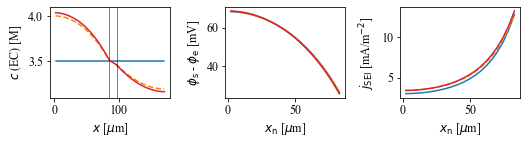

In [62]:
# plot only things happen during 3C CC charge
fs = 12; font = {'family' : 'Times New Roman','size'   : fs}
mpl.rc('font', **font)
def FindClose(time_DD,t_select): # Input must be a list
    for i in range(0,len(time_DD)):
        if abs(time_DD[i] - t_select)<1e-3:
            break
    return i
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
LS = ['-','--','-','--',];MS=['s','^','h']; ms = 8
Sol_plt = [sol_SD,sol_DD_LDx,sol_DD_HDx,];
Str = ["Single",r"Double low D$_\times$",r"Double high D$_\times$"]

t_int_all = []; Index_t_select = []; 

for i in range(3):
    sol = Sol_plt[i]; step_CC =  sol.cycles[0].steps[2]
    t_int_all.append((
        step_CC['Time [s]'].entries
        - step_CC['Time [s]'].entries[0]).tolist())
    print(t_int_all[-1])
t_select = min(t_int_all[0][-2],t_int_all[1][-2],t_int_all[2][-2])
for i in range(3):
    Index_t_select.append(FindClose(t_int_all[i],t_select))
print(Index_t_select,t_select)

fig, axs = plt.subplots(1,3, figsize=(19/2.54,5.5/2.54),tight_layout=True)
for i in range(3):
    sol = Sol_plt[i]; step_CC =  sol.cycles[0].steps[2]
    x =   step_CC["x [m]"].entries[:,0]
    x_n =   step_CC["x_n [m]"].entries[:,0]
    c_EC =   step_CC["EC concentration [mol.m-3]"].entries[:,Index_t_select[i]]
    j_SEI =   step_CC["Negative electrode SEI interfacial current density [A.m-2]"].entries[:,Index_t_select[i]]
    phi_s_phi_e =   step_CC["Negative electrode surface potential difference [V]"].entries[:,Index_t_select[i]]

    axs[0].plot(x*1e6, c_EC/1e3, color=Colors[i],linestyle=LS[i],) # label=r"Single-High $D_\times$" 
    axs[1].plot(x_n*1e6, phi_s_phi_e*1e3, color=Colors[i],linestyle=LS[i]) 
    axs[2].plot(x_n*1e6, abs(j_SEI)*1e3, color=Colors[i],linestyle=LS[i]) 
Y_0p = np.arange(-100,200,50)
axs[0].plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
axs[0].plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)


axs[0].set_xlabel(r"$\mathit{x}$ [$\mu$m]",   )
axs[1].set_xlabel(r"$\mathit{x}_\mathrm{n}$ [$\mu$m]",   )
axs[2].set_xlabel(r"$\mathit{x}_\mathrm{n}$ [$\mu$m]",   )
axs[0].set_ylabel("$\mathit{c}$ (EC) [M]")
axs[1].set_ylabel("$\phi$$_\mathrm{s}$ - $\phi$$_\mathrm{e}$ [mV]")
axs[2].set_ylabel("$\mathit{j}_\mathrm{SEI}$ [mA/m$^{-2}$]")
axs[0].ticklabel_format( 
    axis='x', style='sci',
    scilimits=[-1e3,1e3], useOffset=None, 
    useLocale=None, useMathText=None)

axs[0].set_ylim([3.1,4.1])
#axs[1].set_ylim([-90,130])
#axs[2].set_ylim([-0.1,6.5])
fig.subplots_adjust(wspace=0, hspace=0)
# 85.2 ; 12; 75.6
plt.savefig(BasicPath +  Target+ 
    f"Fig_6_1C_c_EC_j_SEI.png", dpi=1000)
plt.savefig(BasicPath +  Target+ 
    f"Fig_6_1C_c_EC_j_SEI.svg")  